# Business Intelligence and Big Data Exam Synopsis 2021
#### Silas Schotte Bendixen (53155, schotte@ruc.dk) & Magnus Johannsen (63749, magnujo@ruc.dk)

### Business Problem
We have found a dataset on kaggle.com containing attributes about songs on Spotify (https://www.kaggle.com/zaheenhamidani/ultimate-spotify-tracks-db). The dataset contains a total of 18 attributes and 232,725 data points. The attributes that are available are for example valence, danceability and duration. Our goal is to see if we can find a relation between these attributes of a track and its popularity, and to see if we can decide how popular a track will be using machine learning. Business-wise this would be valuable for record labels as well as artists, as they are interested in publishing songs that get on the hit lists and therefore making them a lot of money. 

In [1]:
library(tidyverse)
library(dplyr)
library(class)
library(gmodels)
library(C50)
library(randomForest)
library(rpart)
library(rpart.plot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin



In [2]:
spotifydata_raw = read.csv("data/SpotifyFeatures.csv")

In [3]:
spotifydata = spotifydata_raw

### Data transformation, cleaning and exploratory data analysis

Using the following functions, we can get a quick overview over the dataset and its types, aswell as see if there are any missing values.

In [4]:
str(spotifydata)
anyNA(spotifydata)

'data.frame':	232725 obs. of  18 variables:
 $ genre           : Factor w/ 27 levels "A Capella","Alternative",..: 16 16 16 16 16 16 16 16 16 16 ...
 $ artist_name     : Factor w/ 14564 levels "!!!","¡MAYDAY!",..: 5255 8326 6544 5255 4112 5255 8326 7400 2435 7435 ...
 $ track_name      : Factor w/ 148615 levels "____45_____",..: 18615 93903 32598 31339 91776 69420 97152 70534 50881 70019 ...
 $ track_id        : Factor w/ 176774 levels "00021Wy6AyMbLP2tqij86e",..: 4971 4768 5608 8233 10160 12589 13641 14649 17254 19465 ...
 $ popularity      : int  0 1 3 0 4 0 2 15 0 10 ...
 $ acousticness    : num  0.611 0.246 0.952 0.703 0.95 0.749 0.344 0.939 0.00104 0.319 ...
 $ danceability    : num  0.389 0.59 0.663 0.24 0.331 0.578 0.703 0.416 0.734 0.598 ...
 $ duration_ms     : int  99373 137373 170267 152427 82625 160627 212293 240067 226200 152694 ...
 $ energy          : num  0.91 0.737 0.131 0.326 0.225 0.0948 0.27 0.269 0.481 0.705 ...
 $ instrumentalness: num  0 0 0 0 0.123 0 0 0 0.00086

[1] FALSE

We see that the dataset includes numerical, integer and Factor values. The different variables, and what they actually mean are described here: https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features. Basically, most of the data is ordinal, where Spotify have analyzed and ranked the different tracks with regards to their liveness, danceability and other features, using different feature extraction methods. So for example danceability ranges from 0.0 to 1.0, and the closer the track is to 0 the less danceable it is. 

We also note that the data is already in types that R can work with. All the categorical data is already converted to Factors. However, we find it a bit strange that track_id is of the Factor type, since it would make sense to just keep it as a unique string. However, it did provide us with some useful information, which is that we can see that there are 176774 levels, meaning there must på only 176774 unique track ID's. This is weird because there are 232725 observations in the dataset, and we expect every song to have a unique ``track_id``. Naturally, this led us to think there might be some duplicate tracks in the dataset. We tried searching online for a method to find duplicates and the following cell is from https://stackoverflow.com/questions/16905425/find-duplicate-values-in-r. The cell first makes a table with 2 columns and stores it in `n_occur`. The first column contains the track_id and the second column contain how many time that track_id occurs in the dataset. The second line of the cell filters it so that all the id's that occur more than once are printed.

In [5]:
n_occur = data.frame(table(spotifydata$track_id))
duplicates = n_occur[n_occur$Freq > 1,]
duplicates

,Var1,Freq
5,000xQL6tZNLJzIrtIgxqSl,2
10,001gDjxhKGDSx4sMMAgS9R,2
11,001ifh9Zkyc5DhK7AGQRtK,2
17,002opcRBgYV5jqoh72QcqA,2
18,002PgfoyfrOGiKch4EW8Wm,2
19,002QT7AS6h1LAF5dla8D92,2
26,003eoIwxETJujVWmNFMoZy,3
27,003jyCDLi9dKQcnsdzy64K,2
36,005lwxGU1tms6HGELIcUv9,2
43,007n10xGvSbc7dKgAORVIq,2


We see that there are a lot of ``track_id``'s that seem to occur more than once. To double-check that they are in fact duplicates, we try to search for some of the allegedly duplicate id's.

In [6]:
filter(spotifydata, spotifydata$track_id == "00BNT97AtJ5aB8SSsE5xGH")
filter(spotifydata, spotifydata$track_id == "7zsXy7vlHdItvUSH8EwQss")
filter(spotifydata, spotifydata$track_id == "00De7REGurYkmfrKAh6CU1")
filter(spotifydata, spotifydata$track_id == "7zlt3Eh5zS2IAUsM55ncdk")

genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
Hip-Hop,2 Chainz,Threat 2 Society,00BNT97AtJ5aB8SSsE5xGH,70,0.201,0.617,225800,0.779,0,C#,0.117,-5.084,Major,0.287,83.332,4/4,0.887
Rap,2 Chainz,Threat 2 Society,00BNT97AtJ5aB8SSsE5xGH,70,0.201,0.617,225800,0.779,0,C#,0.117,-5.084,Major,0.287,83.332,4/4,0.887
Pop,2 Chainz,Threat 2 Society,00BNT97AtJ5aB8SSsE5xGH,70,0.201,0.617,225800,0.779,0,C#,0.117,-5.084,Major,0.287,83.332,4/4,0.887


genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
Dance,Major Lazer,Cold Water,7zsXy7vlHdItvUSH8EwQss,71,0.055,0.602,185360,0.797,0,F#,0.187,-5.084,Minor,0.0534,92.928,4/4,0.492
Pop,Major Lazer,Cold Water,7zsXy7vlHdItvUSH8EwQss,72,0.055,0.602,185360,0.797,0,F#,0.187,-5.084,Minor,0.0534,92.928,4/4,0.492
Rap,Major Lazer,Cold Water,7zsXy7vlHdItvUSH8EwQss,72,0.055,0.602,185360,0.797,0,F#,0.187,-5.084,Minor,0.0534,92.928,4/4,0.492


genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
Classical,Wojciech Kilar,Dracula- The Beginning,00De7REGurYkmfrKAh6CU1,33,0.51,0.218,400867,0.104,0.692,B,0.0688,-22.809,Minor,0.047,114.592,3/4,0.0329
Soundtrack,Wojciech Kilar,Dracula- The Beginning,00De7REGurYkmfrKAh6CU1,33,0.51,0.218,400867,0.104,0.692,B,0.0688,-22.809,Minor,0.047,114.592,3/4,0.0329


genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
Electronic,Thievery Corporation,La Force de Melodie (LouLou Ghelichkhani),7zlt3Eh5zS2IAUsM55ncdk,44,0.0472,0.7,247850,0.555,0.109,B,0.0876,-9.389,Minor,0.267,169.492,4/4,0.865
Jazz,Thievery Corporation,La Force de Melodie (LouLou Ghelichkhani),7zlt3Eh5zS2IAUsM55ncdk,45,0.0472,0.7,247850,0.555,0.109,B,0.0876,-9.389,Minor,0.267,169.492,4/4,0.865


We can now confirm that there do indeed exist duplicates in the data. Our initial guess to why this is, is that different tracks can be categorized as different genres. Instead of having one list of possible genres as a feature, the track is duplicated with different genres. Depending on what data analysis we will do this might result in some problems, so we need to keep this in mind.

As an initial step to our exploratory data analysis, we use the following function to get a quick overview into the distribution of the different variables:

In [7]:
summary(spotifydata)

        genre                         artist_name       track_name    
 Comedy    :  9681   Giuseppe Verdi         :  1394   Home   :   100  
 Soundtrack:  9646   Giacomo Puccini        :  1137   You    :    71  
 Indie     :  9543   Kimbo Children's Music :   971   Intro  :    69  
 Jazz      :  9441   Nobuo Uematsu          :   825   Stay   :    63  
 Pop       :  9386   Richard Wagner         :   804   Wake Up:    59  
 Electronic:  9377   Wolfgang Amadeus Mozart:   800   Closer :    58  
 (Other)   :175651   (Other)                :226794   (Other):232305  
                   track_id        popularity      acousticness   
 0UE0RhnRaEYsiYgXpyLoZc:     8   Min.   :  0.00   Min.   :0.0000  
 0wY9rA9fJkuESyYm9uzVK5:     8   1st Qu.: 29.00   1st Qu.:0.0376  
 3R73Y7X53MIQZWnKloWq5i:     8   Median : 43.00   Median :0.2320  
 3uSSjnDMmoyERaAK9KvpJR:     8   Mean   : 41.13   Mean   :0.3686  
 6AIte2Iej1QKlaofpjCzW1:     8   3rd Qu.: 55.00   3rd Qu.:0.7220  
 6sVQNUvcVFTXvlk3ec0ngd:     8

We start by plotting some of the categorical data using histograms:

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

0/4    1/4    3/4    4/4    5/4 
     8   2608  24111 200760   5238

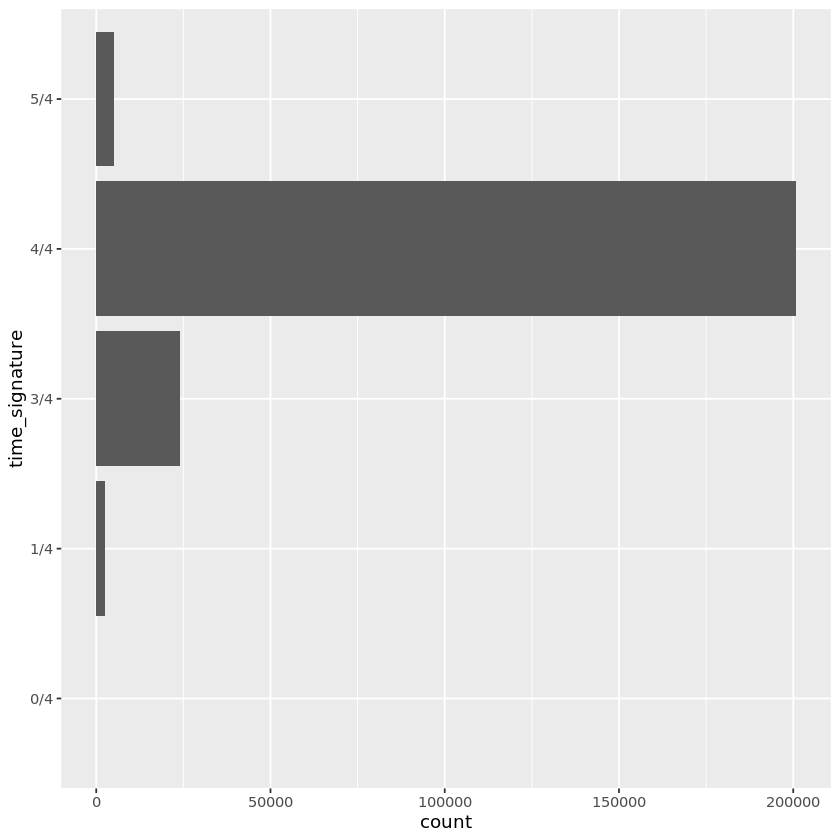

In [8]:
ggplot(data = spotifydata) + geom_histogram(mapping = aes(x = time_signature), stat="count") + coord_flip()
summary(spotifydata$time_signature)

We can see that there are 5 different time signatures, and one of them is 0/4 which doesn't really make sense musically. However it might be difficult to figure out what the time signatures for these 8 tracks are, since we are not music experts, so we chose to just delete them from the dataset, since there are so few of them. 

In [9]:
spotifydata = filter(spotifydata, spotifydata$time_signature != "0/4")

Plotting the distribution of the genres we get the following plot:

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

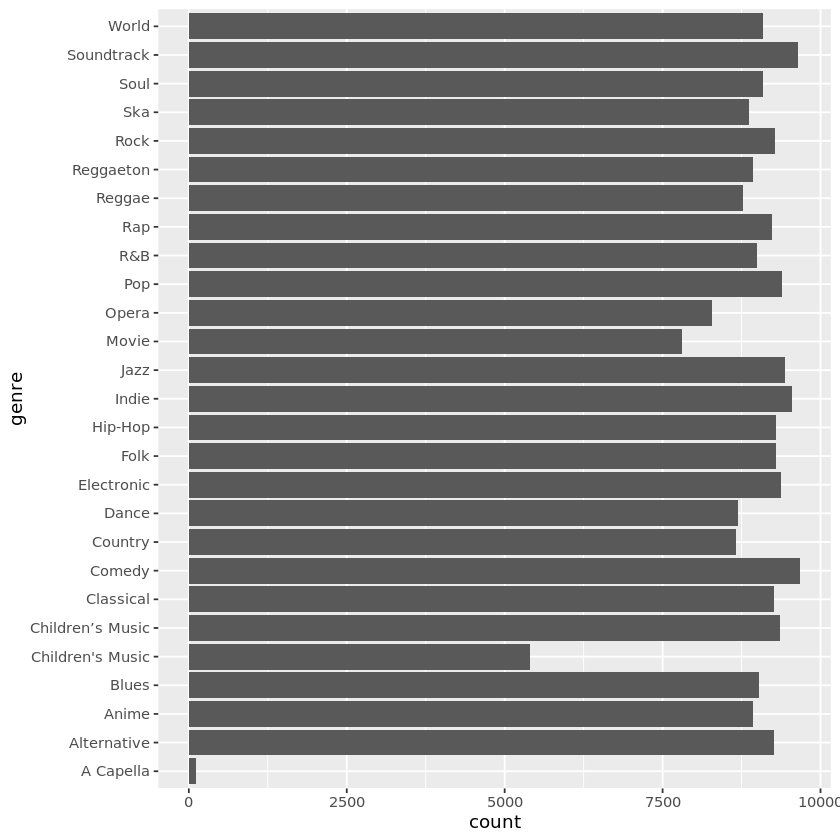

In [10]:
ggplot(data = spotifydata) + geom_histogram(mapping = aes(x = genre), stat="count") + coord_flip()

We see from this plot that the genres are roughly uniformly distributed, except for a cappella which is really sparse. We also notice that there are 2 rows with Children’s Music, that we want to merge together. We figured that they were spelled with different apostrophes. We tried the following, to fix this: 
``spotifydata$genre = str_replace(spotifydata$genre, "Children´s Music", "Children's Music")``. 
However, this didn’t work. Apparently there exist many different apostrophes and the one that was used here is U+2019 : RIGHT SINGLE QUOTATION MARK (U+2019) and APOSTROPHE (U+0027). We used https://www.babelstone.co.uk/Unicode/whatisit.html to figure this out.

The following code finally fixed the issue:

``spotifydata$genre = str_replace(spotifydata$genre, "Children’s Music", "Children's Music")``

However, working with this issue we noticed that that a lot of songs were misclassified as "Children’s Music", and when we try to sample different rows, we can confirm that this is the case:

In [11]:
sample_n(filter(spotifydata, spotifydata$genre == "Children’s Music"), 100)

genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
Children’s Music,Nothing More,If I Were,6lk69KJgnwXwPThivRdMau,48,"5,75e-04","0,448",212293,"0,925","0,00e+00",D,"0,3790","-5,313",Minor,"0,1030","76,148",4/4,"0,404"
Children’s Music,Ween,Ocean Man,6M14BiCN00nOsba4JaYsHW,66,"5,51e-01","0,720",126947,"0,912","1,22e-03",E,"0,0982","-6,130",Major,"0,0363","122,782",4/4,"0,973"
Children’s Music,Styles P,Good Times,7cFpB4ozcSwXuhqjvNbrbP,66,"1,80e-01","0,676",211493,"0,762","0,00e+00",D,"0,7840","-7,483",Major,"0,3130","81,745",4/4,"0,648"
Children’s Music,Story Of The Year,And the Hero Will Drown,3WsgkhWH001sMkbZVcjreS,51,"6,87e-04","0,433",193107,"0,985","0,00e+00",E,"0,4030","-3,358",Minor,"0,2420","100,223",4/4,"0,327"
Children’s Music,Buddy,Trippin' (feat. Khalid),0cMjaVjMi6VPn1mkWPGKka,64,"1,42e-02","0,663",184720,"0,555","6,01e-03",C#,"0,4230","-6,683",Major,"0,0610","134,049",4/4,"0,188"
Children’s Music,TWENTY88,London Bridge,4ShIMQAPiYBkCdHCvLbelR,52,"5,20e-01","0,558",269240,"0,626","0,00e+00",B,"0,3560","-10,553",Major,"0,6060","143,927",4/4,"0,274"
Children’s Music,Switchfoot,Dare You To Move,4x3381mYJqptPqT6OKUfmu,56,"5,73e-03","0,426",247893,"0,881","6,93e-02",E,"0,3890","-4,526",Major,"0,0404","139,986",4/4,"0,259"
Children’s Music,Berhana,80s,58bFfMjShaACL6sAIR1Eyj,46,"7,61e-01","0,576",166892,"0,656","7,60e-06",F,"0,8700","-9,127",Major,"0,3710","139,893",4/4,"0,525"
Children’s Music,Brandon Heath,Give Me Your Eyes,7HQn99HBIBHWkZfTMR8Kki,55,"1,64e-01","0,627",232693,"0,663","0,00e+00",F#,"0,1180","-2,714",Major,"0,0329","90,058",4/4,"0,390"
Children’s Music,Souly Had,Crush,6XFHAb88yMCSWSt5pVSxnE,63,"3,49e-01","0,814",164560,"0,385","4,16e-06",C,"0,1220","-12,230",Major,"0,2520","109,983",3/4,"0,296"


And when doing the same with "Children's Music" (with the other apostrophe), we seem to only get actual music for children, and not Slayer or Slipknot (which we would argue is not exactly music for children): 

In [12]:
sample_n(filter(spotifydata, spotifydata$genre == "Children's Music"), 100)

genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
Children's Music,The Beat Bugs,There's A Place,3iRuXcnUjqoWXfiLiBCmjr,21,"0,0153","0,544",148347,"0,6120","2,13e-05",E,"0,2210","-5,867",Major,"0,0293","146,948",4/4,"0,695"
Children's Music,The Beat Bugs,Rain,3o1lXnZN67kCua4JKRMZO9,20,"0,2490","0,625",193187,"0,7610","1,19e-05",G,"0,1150","-7,241",Major,"0,0815","112,035",4/4,"0,436"
Children's Music,Kimbo Children's Music,Presto (2/4) [32 Bars],64qyOXzI94lTefUmxcAGVd,0,"0,9920","0,693",78120,"0,1670","8,61e-01",E,"0,1040","-16,983",Major,"0,1290","120,281",4/4,"0,736"
Children's Music,StoryBots,Ask The StoryBots Theme,1JaN2fP2SeMc0B8vYCkbRm,27,"0,4520","0,786",60098,"0,6900","0,00e+00",A,"0,2070","-7,421",Major,"0,0687","108,133",4/4,"0,881"
Children's Music,Kimbo Children's Music,Medley: Little Jack Horner / Little Boy Blue,0kg8iY3yCI2Opdv7WpY5dd,0,"0,9790","0,700",111973,"0,1570","3,55e-03",G,"0,1290","-14,085",Major,"0,0368","137,122",3/4,"0,538"
Children's Music,Kimbo Children's Music,Narration / Spoken Interlude 17,1Mm8u6TfySgl8I2kO3nOmb,0,"0,9160","0,668",16760,"0,3600","0,00e+00",G,"0,1220","-12,116",Minor,"0,9180","151,763",1/4,"0,251"
Children's Music,Kimbo Children's Music,Water Sprite Ballet (Moderate 3/4 & 4/4),5E826iTpJxCPNrEXqhCY81,0,"0,9430","0,383",374947,"0,2750","6,45e-01",C,"0,1170","-12,109",Major,"0,0344","118,290",3/4,"0,259"
Children's Music,Children Songs Company,Come and Spend Christmas with Me,6JFEvsC5dHUKahTn0wQq3o,0,"0,9940","0,463",195173,"0,3000","0,00e+00",E,"0,3040","-5,802",Minor,"0,0369","69,703",4/4,"0,403"
Children's Music,Kimbo Children's Music,I Am Special,4pYqC9yXu9eUnt79isFIiX,0,"0,3110","0,885",87147,"0,2040","0,00e+00",C,"0,2200","-14,054",Major,"0,0579","77,392",4/4,"0,913"
Children's Music,Kimbo Children's Music,Toot the Flute (Instrumental),6GtpxNYqucTtJoZUXLdh1l,0,"0,9850","0,567",55813,"0,5650","8,50e-01",A#,"0,1770","-8,324",Major,"0,0560","128,493",4/4,"0,585"


Because of this we decided to just remove all the rows with the genre "Children’s Music".

In [13]:
spotifydata = filter(spotifydata, spotifydata$genre != "Children’s Music")

From the following ``summary`` we can see that the correct data was succesfully removed:

In [14]:
summary(spotifydata$genre)

A Capella      Alternative            Anime            Blues 
             119             9263             8936             9023 
Children's Music Children’s Music        Classical           Comedy 
            5403                0             9256             9680 
         Country            Dance       Electronic             Folk 
            8664             8700             9377             9299 
         Hip-Hop            Indie             Jazz            Movie 
            9295             9543             9441             7806 
           Opera              Pop              R&B              Rap 
            8277             9385             8992             9231 
          Reggae        Reggaeton             Rock              Ska 
            8771             8927             9272             8874 
            Soul       Soundtrack            World 
            9089             9646             9095

We are not sure why there is this error with the dataset. We asked the author on kaggle but have not yet received an answer.

In the following section we will explore relationships between variables in the dataset. As our main business goal is to figure out how to make money as a record label, we naturally want to explore the popularity attribute, and see how different attributes correlates with this. In the following, we will investigate the relation of ``duration_ms`` and ``popularity``. First we simply plot the two using a scatter plot:

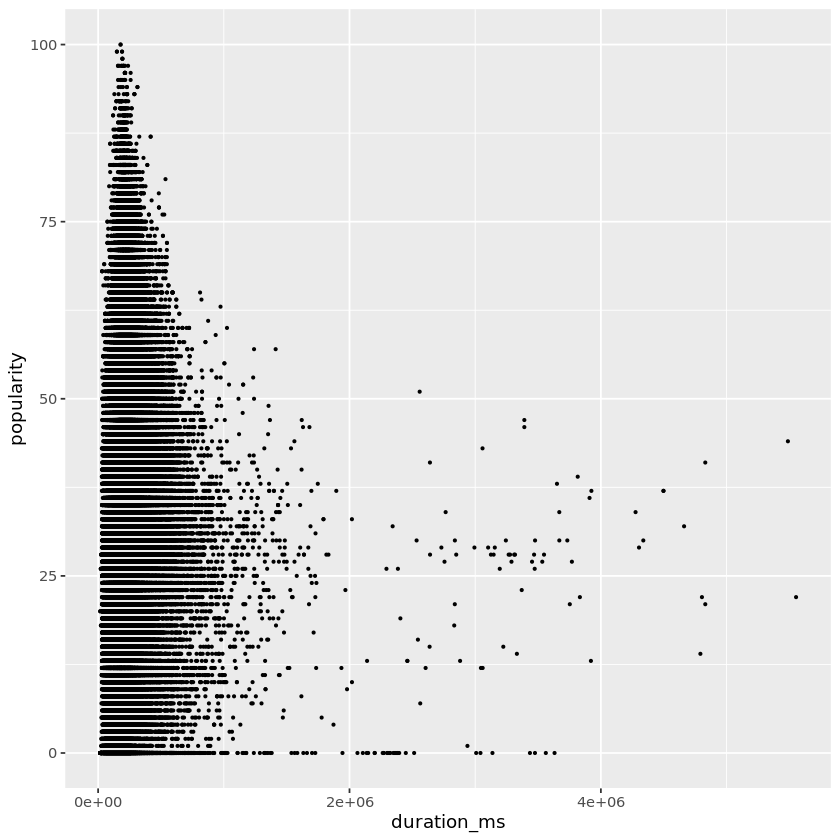

In [15]:
ggplot(data = spotifydata) + geom_point(mapping = aes(x = duration_ms, y = popularity), size = 0.5)

This plot reveals that there are a big chunk of datapoints to the left and a few points to the right. To look into some of the  outliers to the right we did the following plot:

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

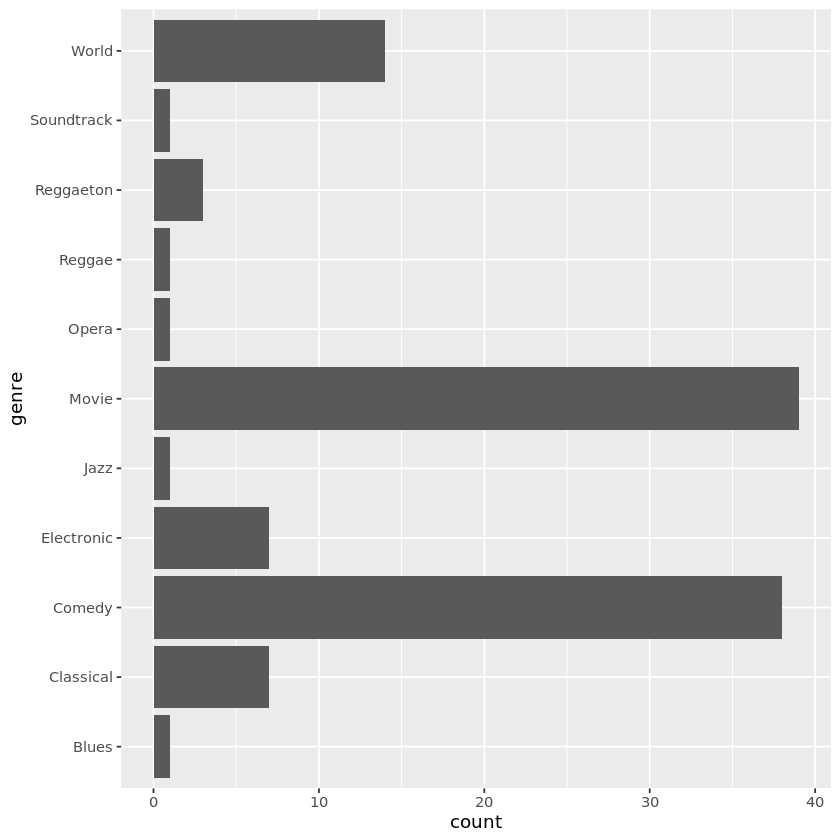

In [16]:
ggplot(data = filter(spotifydata, spotifydata$duration_ms > 1800000)) + geom_histogram(mapping = aes(x = genre), stat="count") + coord_flip()

We can see that there are some Comedy tracks that are quite long. We figured to investigate if these tracks where actually music or infact some kind of podcast. We used the speechiness attribute to clear this up:

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

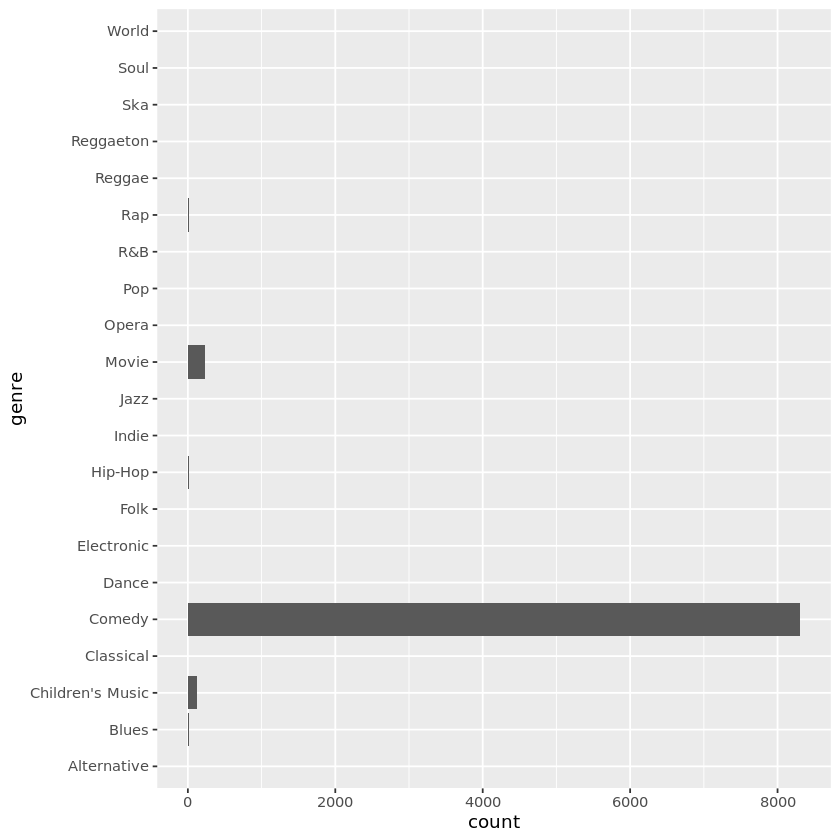

In [17]:
ggplot(data = filter(spotifydata, spotifydata$speechiness > 0.8)) + geom_histogram(mapping = aes(x = genre), stat="count") + coord_flip()

We can see that the comedy tracks are especially high on speechiness, so we figured they are probably some type of podcast, and since we want to focus on music, we remove them.

In [18]:
spotifydata = filter(spotifydata, spotifydata$genre != "Comedy")

Zooming in on the above scatter plot we might be able to get some more details about popularity with regards to duration:

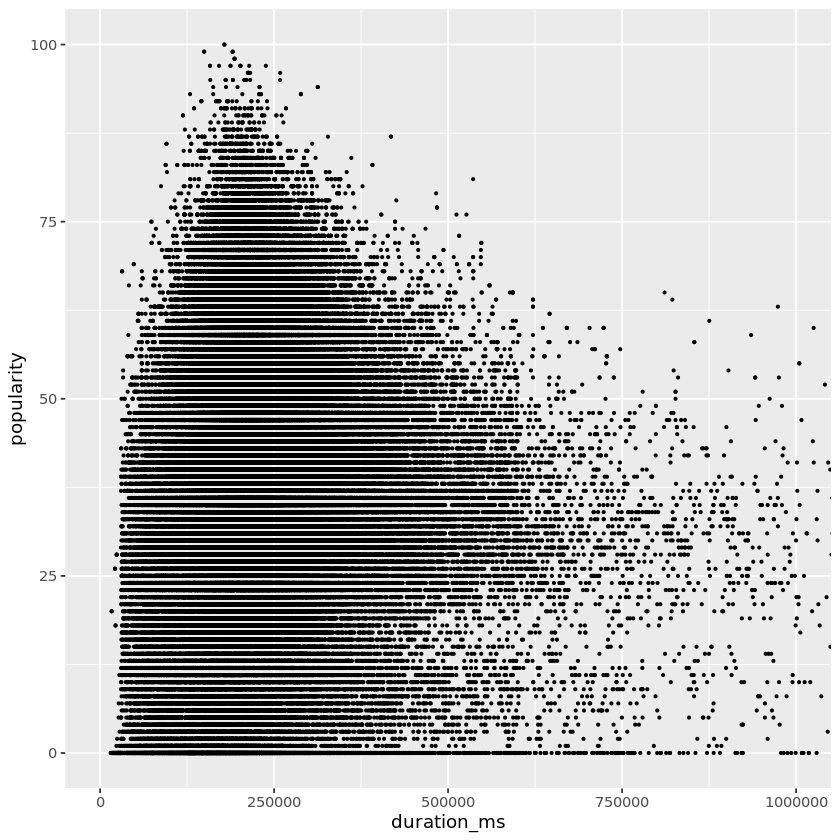

In [19]:
ggplot(data = spotifydata) + geom_point(mapping = aes(x = duration_ms, y = popularity), size = 0.50) + coord_cartesian(xlim = c(0, 1000000))

Here we see that most of the popular songs are around 250000ms long, which is about 4 minutes. This indicates that record labels should release tracks with a duration around that. To get a closer look at this data we split it up into 2 boxplots. One plot focuses on the tracks above 75 popularity and the other focuses on tracks below 75 popularity.

temp$PopularityClass: High
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  73813  190947  213264  217683  237670  536067 
------------------------------------------------------------ 
temp$PopularityClass: Low
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  15387  183814  221067  235517  266253 5488000 

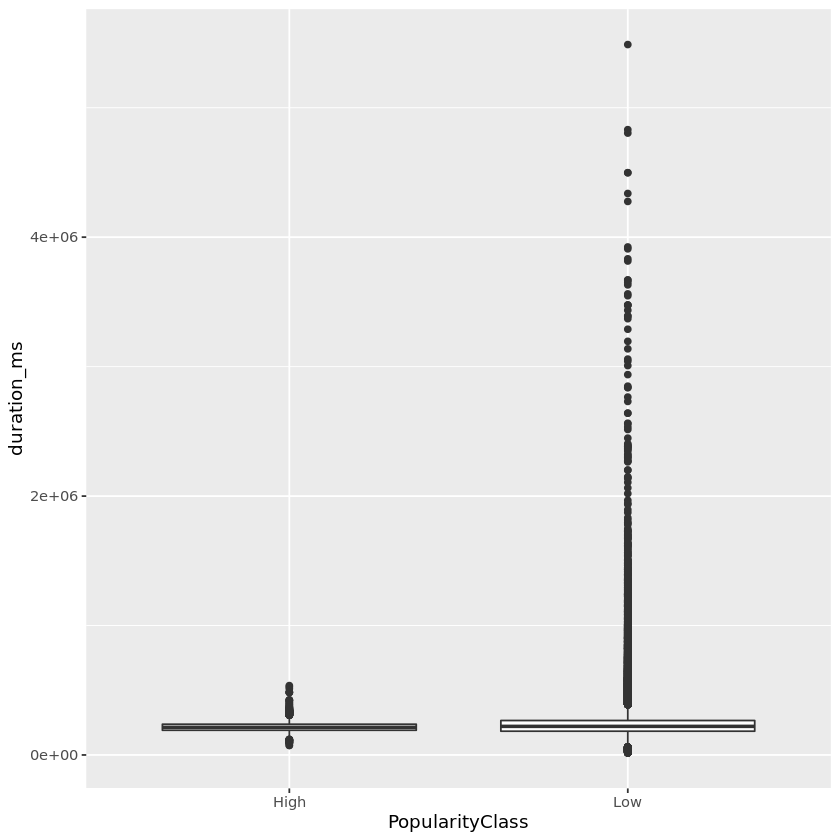

In [20]:
temp = spotifydata %>% mutate(PopularityClass = as.factor(case_when(
          popularity >= 75  ~ "High",
          popularity < 75  ~ "Low",
          )))

ggplot(data = temp) + geom_boxplot(mapping = aes(x = PopularityClass, y = duration_ms))
by(temp$duration_ms, temp$PopularityClass, summary)

From the summary we can see that the quantiles are similar, however the min and max are very different. From the plot we can also see that there are many outliers below 75 popularity.

We also wanted to get a quick overview of the most popular genres so we did the following plot:

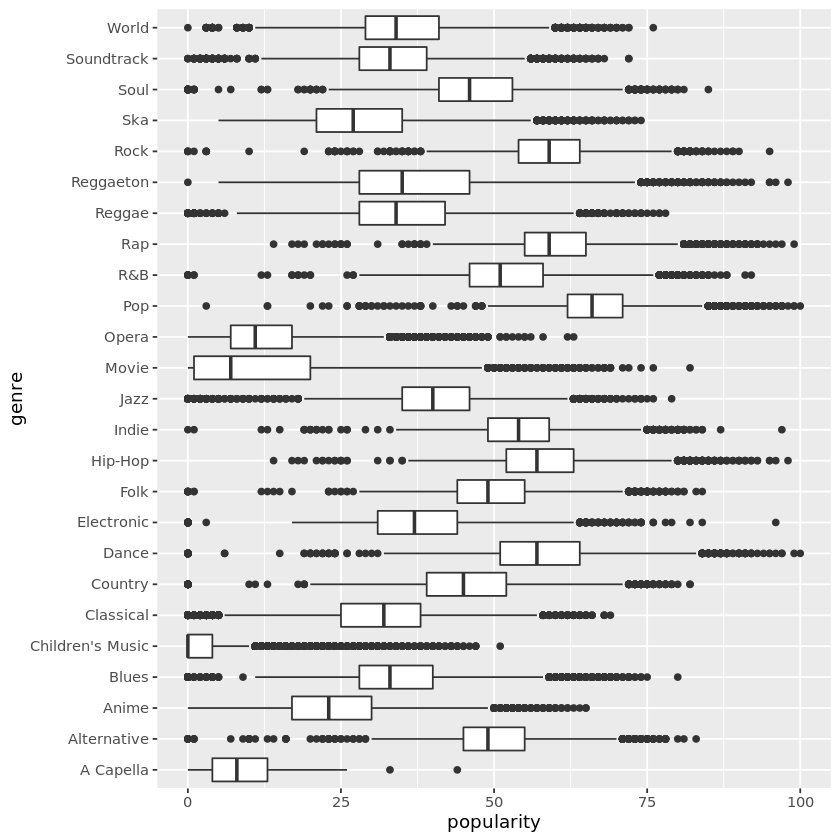

In [21]:
ggplot(data = spotifydata) + geom_boxplot(mapping = aes(x = genre, y = popularity)) + coord_flip()

Below are the descriptive statistics for each genre, supporting the above plot.

In [22]:
by(spotifydata$popularity, spotifydata$genre, summary)

spotifydata$genre: A Capella
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0,000   4,000   8,000   9,303  13,000  44,000 
------------------------------------------------------------ 
spotifydata$genre: Alternative
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0,00   45,00   49,00   50,21   55,00   83,00 
------------------------------------------------------------ 
spotifydata$genre: Anime
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0,00   17,00   23,00   24,26   30,00   65,00 
------------------------------------------------------------ 
spotifydata$genre: Blues
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0,00   28,00   33,00   34,74   40,00   80,00 
------------------------------------------------------------ 
spotifydata$genre: Children's Music
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0,000   0,000   0,000   4,253   4,000  51,000 
------------------------------------------------------------ 
spotifydata$genre: Children’s Music
NULL
-------------

We can see that Pop, Rap, Dance, Rock and Hip-Hop are the most popular genres, which can give a record company an indication that they might want to release tracks within those genres.

The following facet wrap is made to explore the danceability attribute, and how it affect popularity. We start by looking at the distribution of danceability for the different genres:

Warning message:
“Ignoring unknown aesthetics: stat”`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


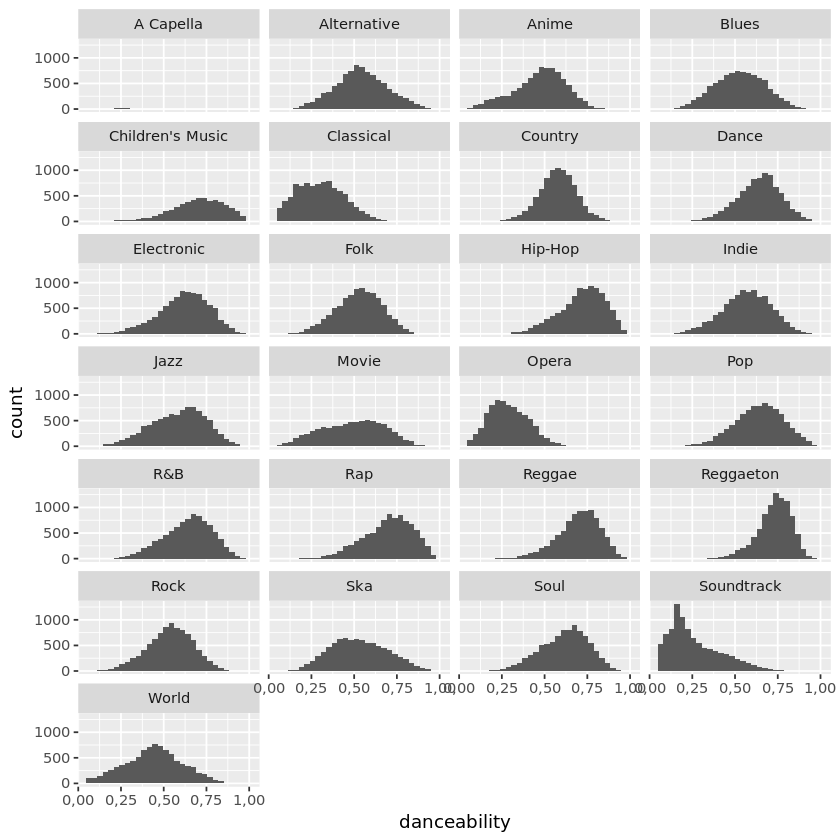

In [23]:
ggplot(data = spotifydata) + geom_histogram(mapping = aes(x = danceability, stat = "count")) + facet_wrap(~ genre, nrow = 8)

The following plot shows the relation between popularity and danceability:

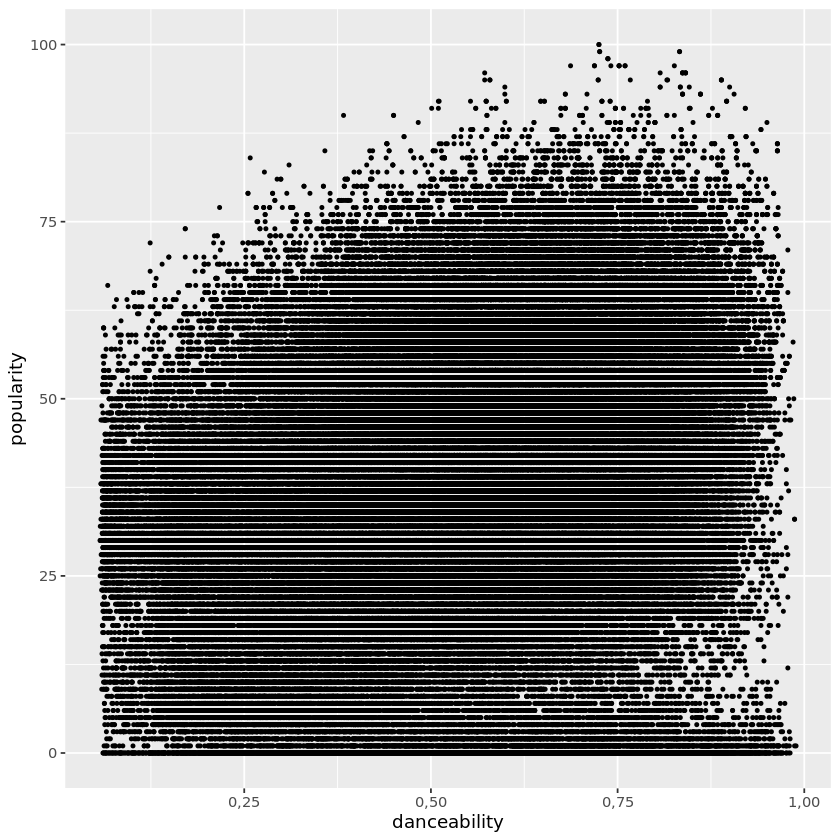

In [24]:
ggplot(data = spotifydata) + geom_point(mapping = aes(x = danceability, y = popularity), size = 0.75)

The following plot is the same as the above, but all other genres than "Dance" are filtered out:

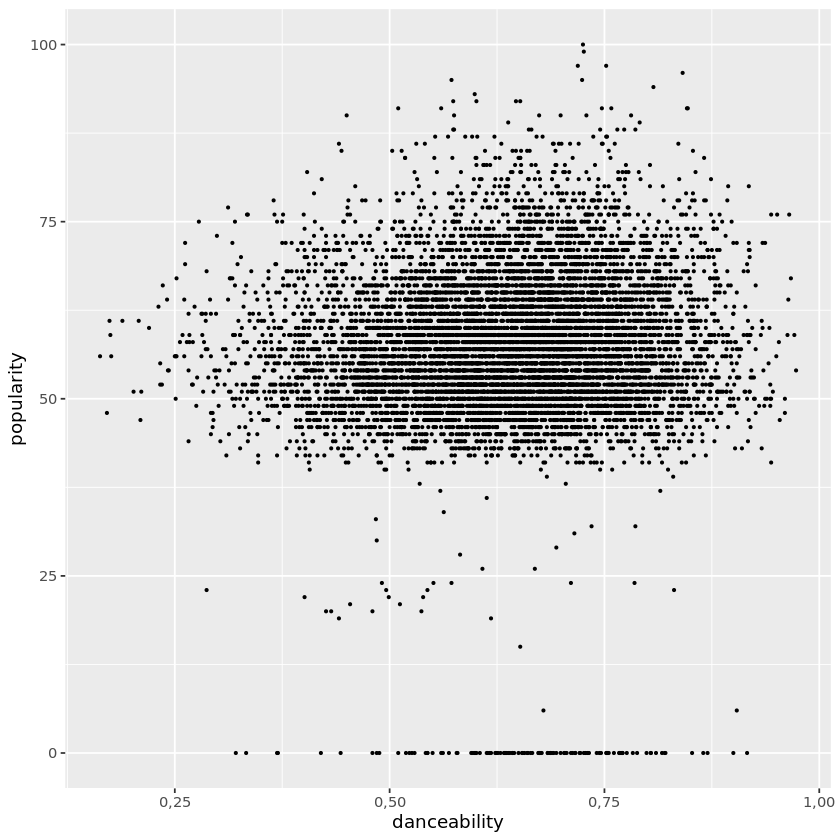

In [25]:
ggplot(data = subset(spotifydata, genre == "Dance")) + geom_point(mapping = aes(x = danceability, y = popularity), size = 0.5)

The following plot shows the relation between tempo and danceability:

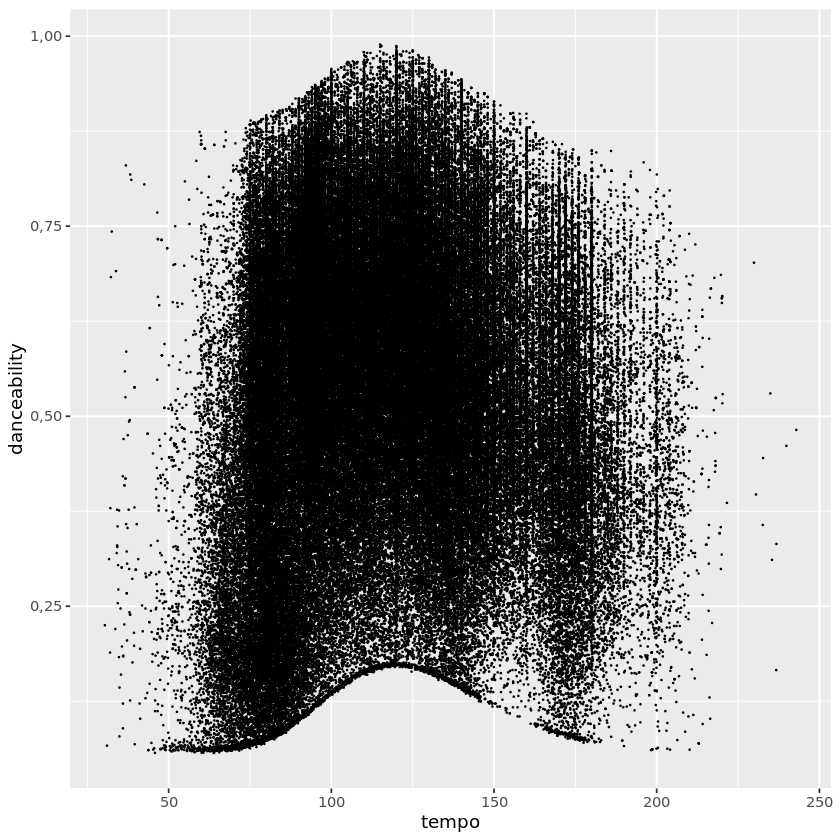

In [26]:
ggplot(data = spotifydata) + geom_point(mapping = aes(x = tempo, y = danceability), size = 0.10)

In the above plot we see that there is some interesting edge shaped as a wave both in the top and the bottom. We suspect that Spotifys algorithm to measure danceability uses tempo as a key feature, and that is why the edge is so "hard".

Generally, we see there is no obvious relation between danceability and popularity to be found (if so, it’s very weak and unnoticeable). Even when focus is on the "Dance" genre, there is no significant relation, except that most of the tracks are over a certain threshold.

### Modeling
In the following, we will try to make a decision tree that classifies songs with regards to popularity. As our dataset do not have different popularity classes, we had to make our own classes based on the ``popularity`` attribute. We found that this popularity class has to be uniformly distributed or the model gets biased i.e., the model has to be trained with a uniformly distributed set of labels. So, we simply make the popularity class based on the ``popularity`` quantiles. Alternatively we could have down sampled/unsampled.


If we can get the model to correctly classify new songs, then record labels might be able to use the model on a specific song before they choose to release it.

In [27]:
spotifydata$genre = factor(spotifydata$genre)
spotifydata$time_signature = factor(spotifydata$time_signature)

In [28]:
summary(spotifydata$popularity)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0,00   30,00   43,00   41,43   55,00  100,00 

In [29]:
spotifydata_features <- spotifydata %>% mutate(PopularityClass = as.factor(case_when(
  popularity >= 55  ~ "Very High",
  popularity < 55 & popularity >= 43  ~ "High",
  popularity < 43 & popularity >= 30  ~ "Low",
  popularity < 30  ~ "Very Low",
  )))

We delete some of the columns, as they are not features that makes sense to classify with.

In [30]:
spotifydata_features = spotifydata_features[,-c(1, 2, 3, 4, 5)]

We split up the data set so 20% of the data is for testing and the rest is for training. First we sample 80% of the indices randomly, and then use those random indices, to make the ``train_data`` set, and the rest to make the ``test_data`` set.

In [31]:
set.seed(4235)
train_ind <- sample(1:nrow(spotifydata_features), size = 0.80 * nrow(spotifydata_features))

In [32]:
train_data <- spotifydata_features[train_ind, ]
test_data <- spotifydata_features[-train_ind, ]

In [33]:
model = rpart(PopularityClass ~ key + mode + acousticness + danceability + duration_ms + energy + instrumentalness + liveness + loudness + speechiness + tempo + time_signature + valence, data = train_data)

We end up with the following decision tree:

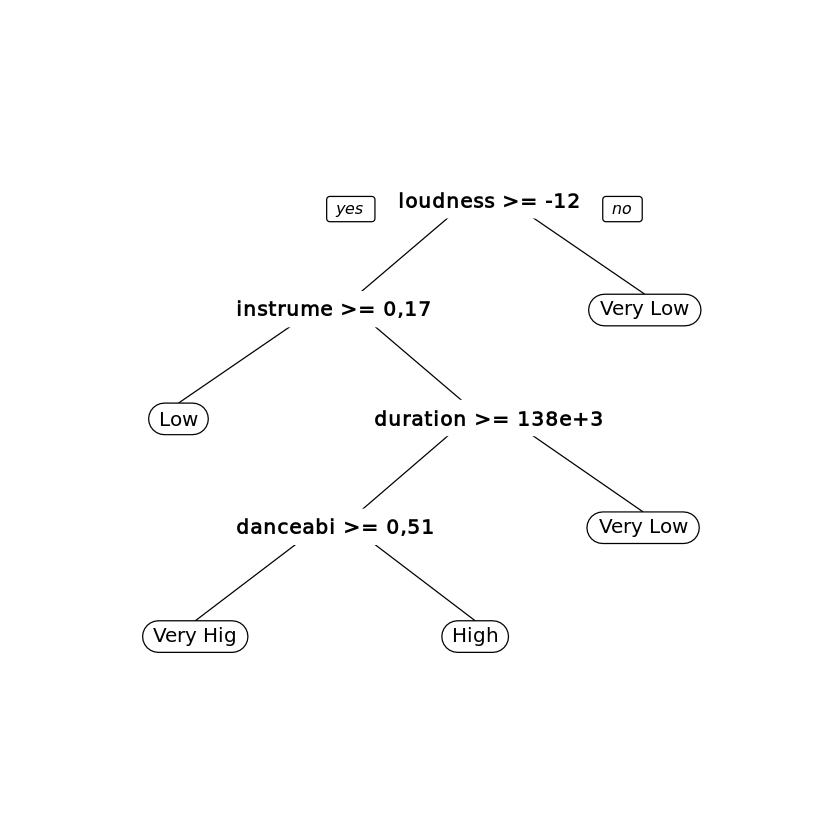

In [34]:
prp(model)

If we highlight the path to "Very High" in the figure below, we can see that the model suggest that if you want a track to be very popular, it is important to have a loudness value above or equal to -12, an instumentalness below 0,17, a duration above or equal to 138e+3 = 138.000ms = 2.3min and a danceability above or equal to 0,51.

![Path](figures/tre1.png)

In [35]:
test_labels = spotifydata_features[-train_ind, "PopularityClass"]

In [36]:
model_test = predict(model, test_data, type = "class") #type = "class" is needed when working with rpart models.

In [37]:
CrossTable(test_labels, model_test, prop.t = FALSE, prop.chisq = FALSE, 
           dnn = c('actual', 'predicted'))


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  42737 

 
             | predicted 
      actual |      High |       Low | Very High |  Very Low | Row Total | 
-------------|-----------|-----------|-----------|-----------|-----------|
        High |      2252 |       992 |      6100 |      1684 |     11028 | 
             |     0,204 |     0,090 |     0,553 |     0,153 |     0,258 | 
             |     0,293 |     0,252 |     0,303 |     0,153 |           | 
-------------|-----------|-----------|-----------|-----------|-----------|
         Low |      1854 |      1445 |      3915 |      3230 |     10444 | 
             |     0,178 |     0,138 |     0,375 |     0,309 |     0,244 | 
             |     0,242 |     0,367 |     0,194 |     0,294 |           | 
-------------|-----------|-----------|-----------|-----------|-----------|
   Very High |

Below we highlight the numbers that are especially important:

![Table 1](figures/table1.png)

We calculate the accuracy to be: (2252 + 1445 + 7352 + 5113) / 42737 = 0.37 = 37%, meaning the model correctly classifies 37% of the time. However, it is mostly relevant to look at how the model is doing when it comes to classifying tracks that are very popular, as this is what is most interesting for our business case.

We can see that 68% of the actual "Very High's" were correctly classified. In other words the Recall is 68%. When we reference Recall in the rest of the notebook it is in relation to "Very High predictions". The model was also generally biased towards predicting "Very High" (47,1 % were predicted as such). Also, of all the "Very High" predictions, it was only 36% that were actually "Very High". In other words, the precision is 36%. When we reference precision in the rest of the notebook we talk about the precision in relation to "Very High predictions". The low precision is not good for the business case, since it leaves 64% uncertainty about the track actually being Very High in popularity. This means that there is a high chance that the record label will release a song they believe is going to be very popular when in fact it is not. However, we can also see that the model tends to mostly misclassify the "High"'s, so the consequence is maybe not that big. The chance to predict a track below "High" as "Very High" is calculated as such: (2772 + 3915) / 20139 = 0.33 = 33%. We will from now on refer to this percentage as unacceptable prediction chance (UPC).

We suspect that making a random forest, instead of just one decision tree will improve the accuracy of the model. We also want to test if removing the duplicates have any effect. We try this first with the simple decision tree:

In [38]:
no_dups = spotifydata %>% distinct(track_id, .keep_all = TRUE)

In [39]:
summary(no_dups$popularity)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0,0    27,0    38,0    37,1    49,0   100,0 

In [40]:
no_dups_features <- no_dups %>% mutate(PopularityClass = as.factor(case_when(
  popularity >= 49  ~ "Very High",
  popularity < 49 & popularity >= 38  ~ "High",
  popularity < 38 & popularity >= 27  ~ "Low",
  popularity < 27  ~ "Very Low",
  )))

In [41]:
summary(no_dups_features$PopularityClass)

High       Low Very High  Very Low 
    41676     39560     43987     41269

In [43]:
no_dups_features = no_dups_features[,-c(1, 2, 3, 4, 5)]

In [45]:
set.seed(4235)
train_ind_ <- sample(1:nrow(no_dups_features), size = 0.80 * nrow(no_dups_features))

In [46]:
train_data_ <- no_dups_features[train_ind_, ]
test_data_ <- no_dups_features[-train_ind_, ]

In [48]:
model_ = rpart(PopularityClass ~ key + mode + acousticness + danceability + duration_ms + energy + instrumentalness + liveness + loudness + speechiness + tempo + time_signature + valence, data = train_data_)

We end up with the following decision tree:

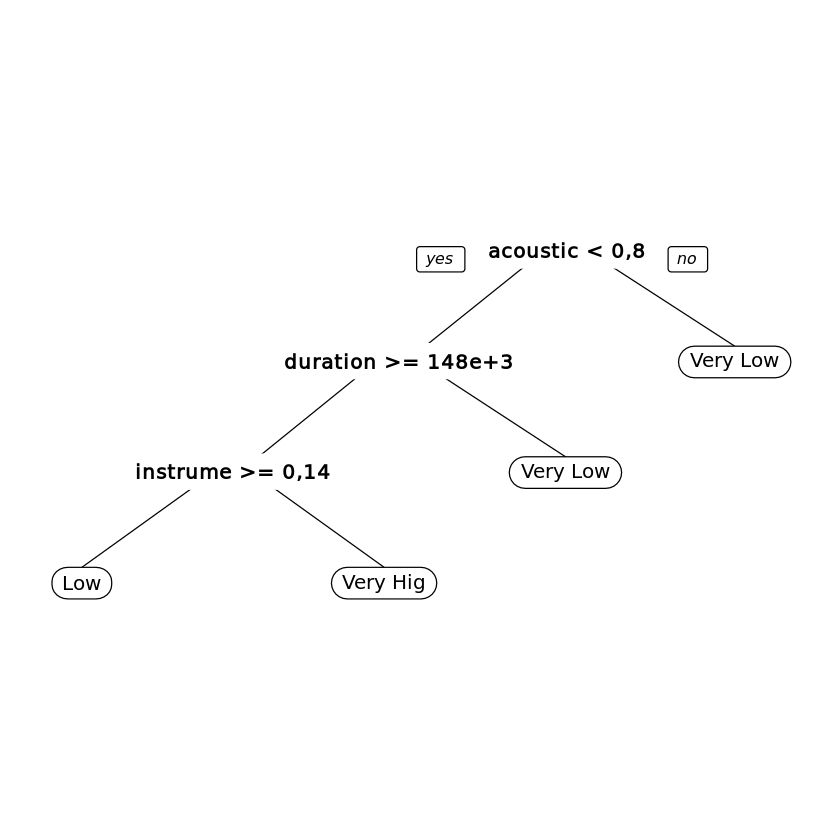

In [49]:
prp(model_)

If we highlight the path to "Very High" in the figure below, we can see that this model suggest that if you want a track to be very popular, it is important to have a acoustic value below 0,8, a duration greater or equal to 148e+3 = 148.000ms = 2,467min and an instrumentalness below 0,14.

![Second Tree](figures/tre2.png)

In [50]:
test_labels_ = no_dups_features[-train_ind_, "PopularityClass"]

In [51]:
model_test_ = predict(model_, test_data_, type = "class")

In [52]:
CrossTable(test_labels_, model_test_, prop.t = FALSE, prop.chisq = FALSE, 
           dnn = c('actual', 'predicted'))


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  33299 

 
             | predicted 
      actual |       Low | Very High |  Very Low | Row Total | 
-------------|-----------|-----------|-----------|-----------|
        High |      1160 |      5452 |      1664 |      8276 | 
             |     0,140 |     0,659 |     0,201 |     0,249 | 
             |     0,314 |     0,278 |     0,167 |           | 
-------------|-----------|-----------|-----------|-----------|
         Low |      1324 |      3990 |      2560 |      7874 | 
             |     0,168 |     0,507 |     0,325 |     0,236 | 
             |     0,359 |     0,203 |     0,257 |           | 
-------------|-----------|-----------|-----------|-----------|
   Very High |       587 |      7112 |      1128 |      8827 | 
             |     0,067 |     0,806 |     0,128 |     0,265 | 
      

Below we highlight the numbers that are especially important:

![Table 1](figures/table2.png)

We calculate the accuracy to be: (1324 + 7112 + 4617) / 42737 = 0.395 = 39,5%.

Recall for "Very High" = 80%

Precision for "Very High" = 36%

UPC is calculated as such: (3084 + 3990) / 19638 = 0.36 = 36%. 

Which means the record label has 36% chance to release a unpopular track that was classified as Very High.

In the following we will make a random forest with and without duplicates in the data set. First with duplicates:

In [54]:
rf <- randomForest(subset(train_data, select = -c(PopularityClass)), train_data$PopularityClass)

In [55]:
rf_pred <- predict(rf, test_data)

In [56]:
CrossTable(test_data$PopularityClass, rf_pred,
           prop.t = FALSE, prop.chisq = FALSE,
           dnn = c('actual', 'predicted'))


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  42737 

 
             | predicted 
      actual |      High |       Low | Very High |  Very Low | Row Total | 
-------------|-----------|-----------|-----------|-----------|-----------|
        High |      6395 |      1775 |      1864 |       994 |     11028 | 
             |     0,580 |     0,161 |     0,169 |     0,090 |     0,258 | 
             |     0,558 |     0,189 |     0,153 |     0,103 |           | 
-------------|-----------|-----------|-----------|-----------|-----------|
         Low |      2374 |      4716 |      1073 |      2281 |     10444 | 
             |     0,227 |     0,452 |     0,103 |     0,218 |     0,244 | 
             |     0,207 |     0,501 |     0,088 |     0,236 |           | 
-------------|-----------|-----------|-----------|-----------|-----------|
   Very High |

Below we highlight the numbers that are especially important:

![rftable](figures/rftable.png)

We calculate the accuracy to be: (6395 + 4716 + 8640 + 5996) / 42737 = 0.60 = 60%.

Recall for "Very High" = 80%
Precision for "Very High" = 70%

UPC is calculated as such: (637 + 1073) / 12214 = 0.14 = 14%. 

In the following we make a random forest without duplicates in the data:

In [57]:
rf_ <- randomForest(subset(train_data_, select = -c(PopularityClass)), train_data_$PopularityClass)

In [58]:
rf_pred_ <- predict(rf, test_data_)

In [59]:
CrossTable(test_data_$PopularityClass, rf_pred_,
           prop.t = FALSE, prop.chisq = FALSE,
           dnn = c('actual', 'predicted'))


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  33299 

 
             | predicted 
      actual |      High |       Low | Very High |  Very Low | Row Total | 
-------------|-----------|-----------|-----------|-----------|-----------|
        High |      4259 |      3479 |       265 |       273 |      8276 | 
             |     0,515 |     0,420 |     0,032 |     0,033 |     0,249 | 
             |     0,519 |     0,371 |     0,047 |     0,027 |           | 
-------------|-----------|-----------|-----------|-----------|-----------|
         Low |       326 |      5377 |       139 |      2032 |      7874 | 
             |     0,041 |     0,683 |     0,018 |     0,258 |     0,236 | 
             |     0,040 |     0,573 |     0,025 |     0,202 |           | 
-------------|-----------|-----------|-----------|-----------|-----------|
   Very High |

Below we highlight the numbers that are especially important:

![rftable2](figures/rftable2.png)

We calculate the accuracy to be: (4259 + 5377 + 5103 + 7663) / 33299 = 0.67 = 67%.

Recall for "Very High" = 58%
Precision for "Very High" = 91%

UPC is calculated as such: (120 + 139) / 5627 = 0.046 = 5%. 

### Discussion on big data storage

As we are doing a lot of processing with the data, we would argue that a data warehouse makes sense here, so that the record label can easily use the data to make the models they want. Since data in a data lake is unstructured and raw, record labels might need access to data scientists, if they want to use data lakes.

This dataset only contains 34MB of data, which is only a tiny fraction of Spotifys data, since Spotify contains more than 70 million tracks. If a record label wanted to store data about all these tracks, they would need a big NoSQL database since the format that the data is delivered through the API is JSON. Here, a data warehouse might also be beneficial, where data is cleaned before stored and therefore takes up less storage space. 
There might not be any reason for the record label to store any data, however. Data is already stored on Spotify's databases and can most likely be obtained through a call to their API.

Furthermore, it might be relevant for the record label to often update their database, as we would argue that seasonality might play a big role in a tracks popularity. Certain song attributes might be popular during summer and others during winter.

### Ethics
In our business case there is not a lot of ethical issues regarding personal information, since this case is focused on advertising data that the artists are interested in getting shared in the first place. However, it’s worth noting that strictly focusing on popular music you would neglect the smaller and less popular genres and hereby suppressing them. Suppressing smaller artists, by promoting them even less, is especially bad since they have a low score in “popularity” to begin with. Furthermore, you could argue that if too many record labels used the same machine learning models, they would all release music which sound the same. However, the biggest record labels already do this to a degree, so we would argue that it would not make a big difference overall.

### Conclusion
The following table shows an overview of the relevants result of the models.

![Photo](figures/table3.png)

At first we see that the random forest models seem most beneficial for our specific business case, especially if you only consider the precision value which is significantly higher, especially for ``rf_``

However, we would argue that both recall and precision are important to maximize for this business case. Both record label and artist are interested in not discarding songs that would have been a commercial success i.e.: to have a model with high recall. At the same time, they would like to correctly identify unpopular songs and not misclassify them as popular i.e.: to have a model with high precision.

Even though the recall is higher in the model_ we would argue that the random forest models are better for our business case since they score a lot higher in Precision than both ``model`` and ``model_``. Since ``rf`` has both a relatively high recall and precision, you could argue that this is the best model. However, in the ``CrossTable`` of ``rf`` we see that it mostly predicted "Very High" relative to the other labels, whereas ``rf_`` had a low number of "Very High" predictions relative to the other labels. 

Even though the random forests are best at classifying, they do not indicate which variables and thresholds that are relevant for making a track popular as the single decision trees did. Record labels might find this information valuable which is why we display an overview of them in the following tables.


In [60]:
vars = c("loudness", "instrumentalness", "duration", "danceability")
rel = c(">=", "<", ">=", ">=")
val = c("-12", "0,17", "2.3min", "0,51")
treetable1 = data.frame(vars, rel, val)
colnames(treetable1) = NULL
print("model")
treetable1

[1] "model"


loudness,>=,-12
instrumentalness,<,"0,17"
duration,>=,2.3min
danceability,>=,"0,51"


In [61]:
vars = c("acousticness", "duration", "instrumentalness")
rel = c("<", ">=", ">")
val = c("0,8", "2.667min", "0,14")
treetable2 = data.frame(vars, rel, val)
colnames(treetable2) = NULL
print("model_")
treetable2

[1] "model_"


acousticness,<,"0,8"
duration,>=,2.667min
instrumentalness,>,"0,14"


However, these tables are based on models with low precision, so it would be risky to use them as guideline to make popular tracks. 

All in all, these models do not take marketing/promotion of a track into consideration. Future models should include data from these areas, as it naturally has a lot to say in how popular it is going to be.